# Data Analysis
### Predictive modelling of stroke occurences

Import libraries

In [158]:
import pandas as pd
from utils import DataLoader, Performance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('once')
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

Load data

In [159]:
data_loader = DataLoader("healthcare-dataset-stroke-data.csv")
data_loader.load_dataset()

# Preprocess data
- Using the preprocessing pipeline from Utils based on the findings from the data exploration 
- Undersample to account for the imbalance in the data set

In [160]:
data_loader.preprocess_data()
# Split the data for testing and training for ANN 
X_train, X_test, X_val, y_train, y_test, y_val = data_loader.get_data_split(ANN = True)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Oversample the train data 
X_train, y_train = data_loader.undersample(X_train, y_train)
print("After undersampling:", X_train.shape)

(3065, 20)
(1022, 20)
(1022, 20)
After undersampling: (308, 20)


In [161]:
# Check data
X_train

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,61.0,0.0,0.0,84.12,25.1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,33.0,0.0,0.0,112.94,43.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,50.0,0.0,0.0,85.77,21.1
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.0,0.0,0.0,227.04,23.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,43.0,0.0,0.0,82.57,29.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,1.0,0.0,74.90,22.2
304,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,74.0,0.0,0.0,98.55,25.6
305,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,104.12,23.5
306,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,76.0,0.0,0.0,57.92,28.1


## Fit models
- ANN
- Random Forest
- XGBoost

### ANN

In [162]:
#Scale and Fit the data
# Scaling is needed which it is not for random forest or XGBoost
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [163]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.random.set_seed(2)

#### Define model

In [167]:
#ANN MODEL
model = Sequential()

model.add(Dense(units = 14, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 7, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 3, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy') # metrics=[tf.keras.metrics.FalsePositives()]

#### Define early stopping callback

In [168]:
#stops when validation loss is not dropping for 3 epochs
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
# Rule of thumb, patience is 10% of the number of epochs 
# We need to save the model 
callbacks = [EarlyStopping(monitor='val_loss', patience=12),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#### Fit model

In [169]:
#Fitting model
model.fit(X_train_scaled, y_train, 
          epochs = 150,
         validation_data=(X_val_scaled, y_val),
         verbose = 1, 
         callbacks=callbacks, batch_size=30)

Epoch 1/150
11/11 [==============================] - 2s 47ms/step - loss: 0.7110 - false_positives: 105.0000 - val_loss: 0.7385 - val_false_positives: 646.0000
Epoch 2/150
11/11 [==============================] - 0s 13ms/step - loss: 0.7091 - false_positives: 99.0000 - val_loss: 0.7261 - val_false_positives: 607.0000
Epoch 3/150
11/11 [==============================] - 0s 15ms/step - loss: 0.6991 - false_positives: 88.0000 - val_loss: 0.7190 - val_false_positives: 581.0000
Epoch 4/150
11/11 [==============================] - 0s 15ms/step - loss: 0.6965 - false_positives: 88.0000 - val_loss: 0.7154 - val_false_positives: 568.0000
Epoch 5/150
11/11 [==============================] - 0s 13ms/step - loss: 0.6934 - false_positives: 92.0000 - val_loss: 0.7114 - val_false_positives: 538.0000
Epoch 6/150
11/11 [==============================] - 0s 15ms/step - loss: 0.6879 - false_positives: 85.0000 - val_loss: 0.7067 - val_false_positives: 484.0000
Epoch 7/150
11/11 [==========================

Text(0.5, 1.0, 'Training loss and accuracies')

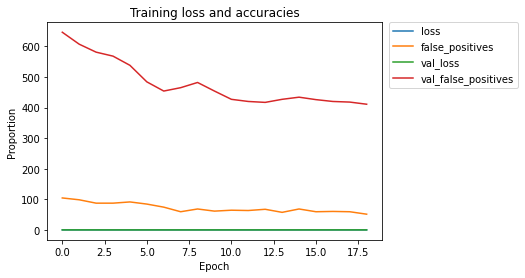

In [170]:
# Visualize training
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Training loss and accuracies")

##### Performance of ANN model

In [171]:
# First we load the best model
from keras.models import load_model
saved_model = load_model('best_model.h5')

#Predictions
prediction_values = saved_model.predict(X_test_scaled)
# Convert into classes 
prediction_best = []
for i in prediction_values:
    prediction_best.append(np.where(i > 0.5, 1,0)[0])

performance = Performance()
saved_model_performance = performance.evaluate(test_labels = y_test, predictions = prediction_best)

32/32 [==============================] - 0s 2ms/step
Model Performance
Accuracy = 50.39%.
Recall strokes only = 56.86%.


We also check the last model since we were optimizing for accuracy, the recall of strokes might be better here

In [172]:
#Predictions
prediction_values = model.predict(X_test_scaled)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])

model_performance = performance.evaluate(test_labels = y_test, predictions = prediction)

32/32 [==============================] - 0s 2ms/step
Model Performance
Accuracy = 55.58%.
Recall strokes only = 74.51%.


Since this model did perform better in terms of recalling strokes we choose th elast model as the best model. 

We make classification report and confusion matrix

In [173]:
print(classification_report(y_test,prediction))

cf = confusion_matrix(y_test,prediction)

              precision    recall  f1-score   support

           0       0.98      0.55      0.70       971
           1       0.08      0.75      0.14        51

    accuracy                           0.56      1022
   macro avg       0.53      0.65      0.42      1022
weighted avg       0.93      0.56      0.67      1022



Visualize with a Heatmap

[[530 441]
 [ 13  38]]


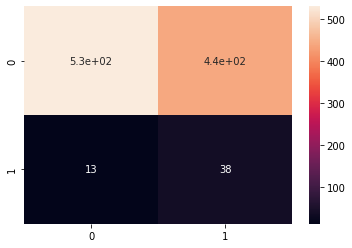

In [174]:
import seaborn as sns
sns.heatmap(cf, annot=True)
print(cf)

### XGBoost

Now we split again to not have the val data for these models

In [30]:
X_train, X_test, y_train, y_test = data_loader.get_data_split(ANN = False)
print(X_train.shape)
print(X_test.shape)

# Oversample the train data 
X_train, y_train = data_loader.undersample(X_train, y_train)
print("After undersampling:", X_train.shape)

(4087, 20)
(1022, 20)
After undersampling: (396, 20)


In [32]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric= 'error')
XGB.fit(X_train, y_train) # Fit model
y_pred = XGB.predict(X_test) # Make predictions


print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       971
           1       0.11      0.71      0.20        51

    accuracy                           0.71      1022
   macro avg       0.55      0.71      0.51      1022
weighted avg       0.94      0.71      0.79      1022


Model Performance
Accuracy = 71.04%.
Recall strokes only = 70.59%.


[[690 281]
 [ 15  36]]


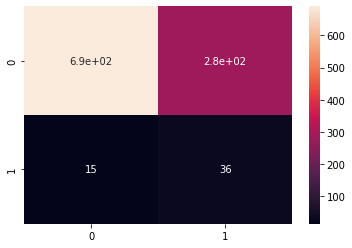

In [34]:
sns.heatmap(cf, annot = True)
print(cf)

### Random Forest

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train.values, y_train)
y_pred = rf.predict(X_test.values)
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
XGB_performance = performance.evaluate(test_labels = y_test, predictions = y_pred)

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       971
           1       0.12      0.82      0.22        51

    accuracy                           0.70      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.70      0.79      1022


Model Performance
Accuracy = 70.06%.
Recall strokes only = 82.35%.


In [79]:
rf.max_features

'auto'

[[674 297]
 [  9  42]]


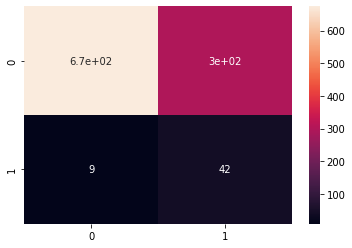

In [42]:
sns.heatmap(cf, annot = True)
print(cf)

#### Attempt to optimize rf

#### Tuning RF

We do cross validation. 
First we define a grid of parameters

In [47]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Random search and fit


In [48]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [49]:
# View best parameters from fitting
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

#### Evaluate Random search
Evaluate the random search based on recall of class 1 (stroke) only. 
Recall answers what proportion of actual positives aka strokes was identified correctly? But in this case only among the strokes patients since this is the parameter that needs optimization. 

Base model meaning evaluating the training

In [50]:
train_preds = rf.predict(X_train)
print(classification_report(y_train,train_preds))
print()
cf = confusion_matrix(y_train,train_preds)
RF_performance = performance.evaluate(test_labels = y_train, predictions = train_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       1.00      1.00      1.00       198

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396


Model Performance
Accuracy = 100.00%.
Recall strokes only = 100.00%.


X has feature names, but RandomForestClassifier was fitted without feature names


The best model from the random estimator (OBS no difference)

In [51]:
best_random = rf_random.best_estimator_
preds = best_random.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       971
           1       0.12      0.82      0.22        51

    accuracy                           0.70      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.70      0.79      1022


Model Performance
Accuracy = 70.16%.
Recall strokes only = 82.35%.


[[673 298]
 [  9  42]]


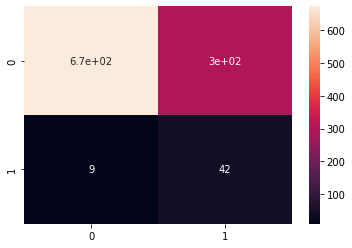

In [57]:
sns.heatmap(cf, annot = True)
print(cf)

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

#### Grid search (no difference in performance)

In [53]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70],
    'max_features': [2, 4], # sqrt of total number of featuers in data
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500, 700, 900]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [54]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 700}

Evaluate the performance of the grid search

In [55]:
best_grid = grid_search.best_estimator_
preds = best_grid.predict(X_test)
print(classification_report(y_test,preds))
print()
cf = confusion_matrix(y_test,preds)
RF_performance = performance.evaluate(test_labels = y_test, predictions = preds)

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       971
           1       0.12      0.82      0.21        51

    accuracy                           0.70      1022
   macro avg       0.56      0.76      0.51      1022
weighted avg       0.94      0.70      0.78      1022


Model Performance
Accuracy = 69.96%.
Recall strokes only = 82.35%.


[[673 298]
 [  9  42]]


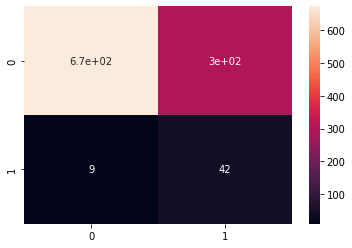

In [58]:
sns.heatmap(cf, annot = True)
print(cf)

Change threshold to make the model more sensitive to stroke cases   

              precision    recall  f1-score   support

           0       0.99      0.60      0.75       971
           1       0.11      0.90      0.19        51

    accuracy                           0.62      1022
   macro avg       0.55      0.75      0.47      1022
weighted avg       0.95      0.62      0.72      1022

[[585 386]
 [  5  46]]


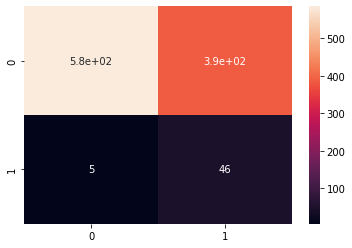

In [73]:
prediction_values = best_grid.predict_proba(X_test) # also try with the "best models"

threshold = 0.4
predicted = (prediction_values [:,1] >= threshold).astype('int')

print(classification_report(y_test, predicted))

cf__new_threshhold = confusion_matrix(y_test,predicted)
sns.heatmap(cf__new_threshhold, annot = True)
print(cf__new_threshhold)


Four more stroke patients gets correctly classified but 88 more incorecctly classified non-stroke patients. 

#### Interpretation try ANN

In [155]:
import lime.lime_tabular
x_np = X_train.to_numpy()
x_np_test = X_test.to_numpy()
# changed x to x_train
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=list(X_train), class_names=[0, 1], mode='classification')
# added top_labels=1
exp = explainer.explain_instance(x_np_test[2], model.predict, num_features = 11, top_labels=1)

157/157 [==============================] - 0s 1ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [157]:
#model.predict(x_np)


TypeError: in user code:

    File "c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Bruger\anaconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1833, in step_function  **
        data = next(iterator)

    TypeError: 'Tensor' object is not an iterator
